In [1]:
# Check that the GPU is operational
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import os
import pydicom as dicom
import matplotlib.pyplot as plt
import jax
from jax import numpy as jnp
import numpy as np

In [17]:
def find_contours(ds_ct, ds_structure):
    # Find the sets of contour points for a given ct image ID. Returns an array  
    # of tuple arrays. slice_id is a string and ds_structure is a dicom file.
    ct_contours = []
    slice_id = ct_id = ds_ct.SOPInstanceUID
    for i in range(len(ds_structure.ROIContourSequence)):
        for j in range(len(ds_structure.ROIContourSequence[i].ContourSequence)):
            for k in range(len(ds_structure.ROIContourSequence[i].ContourSequence[j].ContourImageSequence)):
                if ds_structure.ROIContourSequence[i].ContourSequence[j].ContourImageSequence[k].ReferencedSOPInstanceUID == slice_id:
                    
                    point_number = ds_structure.ROIContourSequence[i].ContourSequence[j].NumberOfContourPoints
                    contour_array_old_coords = np.reshape(ds_structure.ROIContourSequence[i].ContourSequence[j].ContourData, (point_number, 3))
                    new_x = (contour_array_old_coords[:,0] - ds_ct.ImagePositionPatient[0])/ ds_ct.PixelSpacing[0]
                    new_y = (contour_array_old_coords[:,1] - ds_ct.ImagePositionPatient[1])/ ds_ct.PixelSpacing[1]
                    xy_pairs = list(zip(new_x, new_y))
                    ct_contours.append(xy_pairs)

    return ct_contours


In [16]:
def store_ct_with_contours(ct_path, structure_path):
    # Takes a ct scan with its structural information, assures it is stored on the
    # GPU then outputs this information arrays
    ds_struct = dicom.dcmread(structure_path)
    ds_ct = dicom.dcmread(ct_path)
    ct_id = ds_ct.SOPInstanceUID
    ct_array = ds_ct.pixel_array
    ct_contours = find_contours(ds_ct, ds_struct)
    jax.device_put(ct_array)
    jax.device_put(ct_contours)

    return ct_array, ct_contours

# Implementation example: 

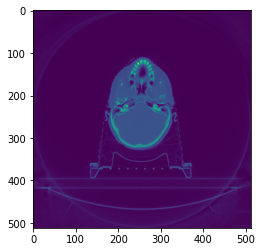

In [24]:
structure_path = "/content/drive/MyDrive/Colab Notebooks/New Head Data/HNSCC/HNSCC-01-0001/12-05-1998-NA-RT SIMULATION-43582/1.000000-NA-78710/1-1.dcm"

ct_path = "/content/drive/MyDrive/Colab Notebooks/New Head Data/HNSCC/HNSCC-01-0001/12-05-1998-NA-RT SIMULATION-43582/NA-28768/2-013.dcm"

my_image, my_contours = store_ct_with_contours(ct_path, structure_path)

plt.imshow(my_image)

#plt.imshow(jnp.multiply(my_image, my_image))
